In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv("sea_level_rise.csv")

In [3]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#Display Dataset
print(df)

          Month       Value
0    01-12-1992   -5.160000
1    01-01-1993   23.706667
2    01-02-1993    9.506667
3    01-03-1993   31.673333
4    01-04-1993   54.590000
5    01-05-1993   72.906667
6    01-06-1993   41.506667
7    01-07-1993   14.640000
8    01-08-1993  -52.485000
9    01-09-1993  -49.360000
10   01-10-1993  -52.960000
11   01-11-1993  -39.026667
12   01-12-1993  -34.560000
13   01-01-1994    6.940000
14   01-02-1994    5.140000
15   01-03-1994   18.240000
16   01-04-1994   48.506667
17   01-05-1994   69.673333
18   01-06-1994   45.840000
19   01-07-1994  -12.993333
20   01-08-1994  -42.793333
21   01-09-1994  -45.693333
22   01-10-1994  -46.885000
23   01-11-1994  -29.260000
24   01-12-1994  -18.860000
25   01-01-1995  -11.060000
26   01-02-1995    5.940000
27   01-03-1995   26.740000
28   01-04-1995   63.973333
29   01-05-1995   58.790000
30   01-06-1995   44.006667
31   01-07-1995   -5.110000
32   01-08-1995  -15.460000
33   01-09-1995  -34.793333
34   01-10-1995  -41

In [5]:
df.set_index('Month',inplace=True)

In [6]:
df.head()

,Value
Month,
01-12-1992,-5.160000
01-01-1993,23.706667
01-02-1993,9.506667
01-03-1993,31.673333
01-04-1993,54.590000


<Axes: xlabel='Month'>

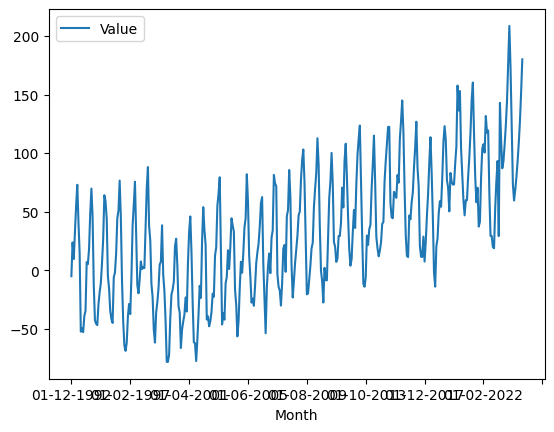

In [7]:
df.plot()

In [8]:
#ADD FULLER TEST

from statsmodels.tsa.stattools import adfuller

In [9]:
test_result=adfuller(df['Value'])

In [10]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(value):
    result=adfuller(value)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adfuller_test(df['Value'])

ADF Test Statistic : -0.49045746174734217
p-value : 0.8938652451753348
#Lags Used : 16
Number of Observations Used : 367
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
len(df)

384

In [13]:
# Train-test split
train = df.iloc[:372]
test = df.iloc[372:]

In [14]:
# Data scaling
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
# Time series generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [16]:
# LSTM Model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [17]:
# Model training
model.fit(generator, epochs=50)

Epoch 1/50
360/360 [==============================] - 9s 11ms/step - loss: 0.0283
Epoch 2/50
360/360 [==============================] - 4s 12ms/step - loss: 0.0111
Epoch 3/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0081
Epoch 4/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0072
Epoch 5/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0071
Epoch 6/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0066
Epoch 7/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0064
Epoch 8/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0061
Epoch 9/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0058
Epoch 10/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0055
Epoch 11/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0061
Epoch 12/50
360/360 [==============================] - 4s 11ms/step - loss: 0.0058
Epoch 13/50
3

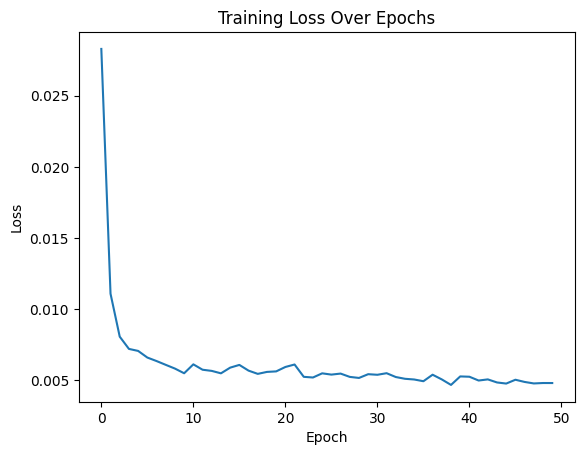

In [18]:
# Loss plot
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [19]:
# Predictions on test data
test_predictions = []

In [20]:
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [21]:
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 48ms/step


In [22]:
# Inverse transform to get original scale
true_predictions = scaler.inverse_transform(test_predictions)

In [23]:
# Create a DataFrame for predictions
test['Predictions'] = true_predictions

C:\Users\HEMANT\AppData\Local\Temp\ipykernel_3660\3685156050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


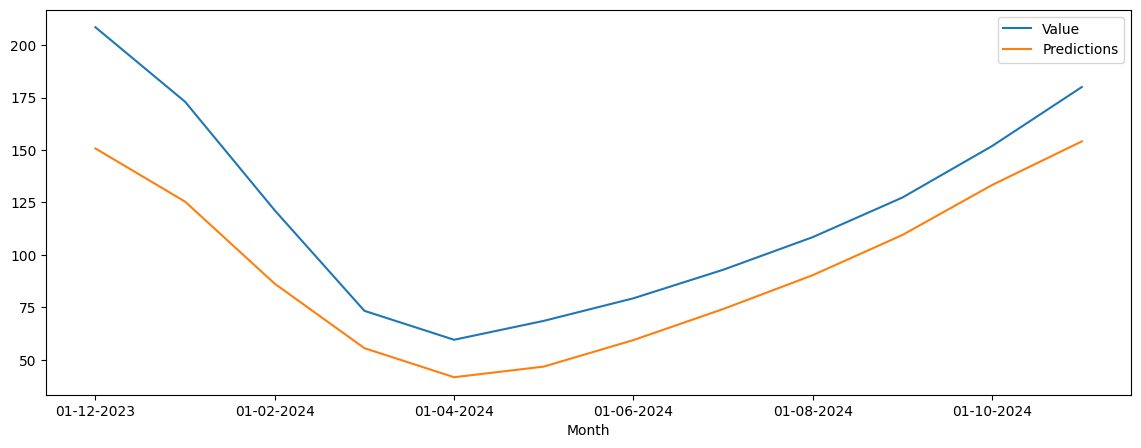

In [24]:
# Plot the results
test[['Value', 'Predictions']].plot(figsize=(14, 5))
plt.show()

Prediction for next 24 Months

In [26]:
# Assuming df is your original DataFrame and n_input, n_features are defined
extended_time_series = df.copy()

for _ in range(24):  # predicting the next 2 years (24 months)
    current_batch = np.array(extended_time_series['Value'][-n_input:]).reshape((1, n_input, n_features))
    current_pred = model.predict(current_batch)[0]

    # Convert the last index to datetime and then add the DateOffset
    last_index = pd.to_datetime(extended_time_series.index[-1])
    next_month = last_index + pd.DateOffset(months=1)

    # Append the prediction with the next month's date
    extended_time_series.loc[next_month] = current_pred[0]

1/1 [==============================] - 0s 44ms/step


In [27]:
# Inverse transform to get original scale for predictions
extended_predictions = scaler.inverse_transform(np.array(extended_time_series['Value'][-24:]).reshape(-1, 1))

In [28]:
# Update the last 24 months' predictions in the DataFrame
extended_time_series['Predictions'] = None
extended_time_series.loc[extended_time_series.index[-24]:, 'Predictions'] = extended_predictions

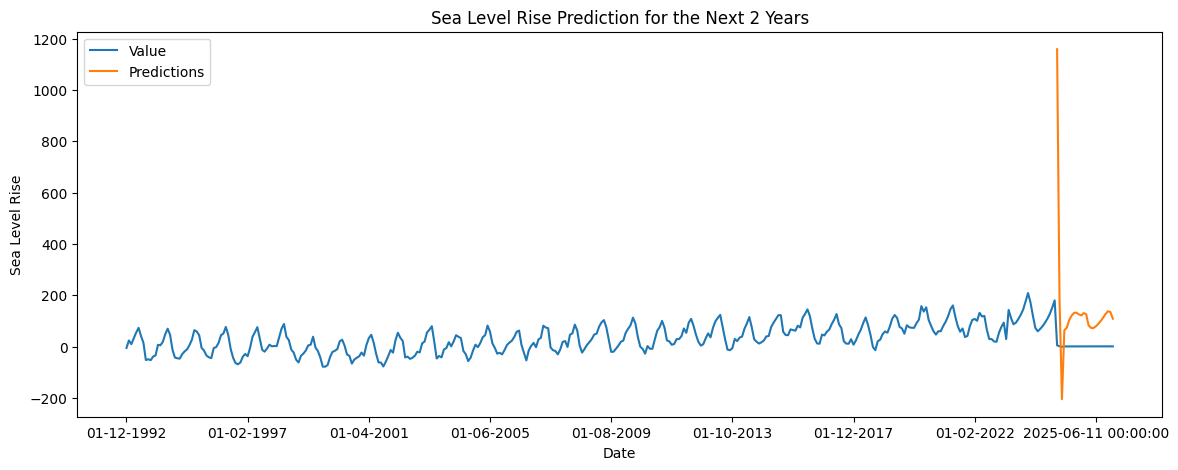

In [29]:
# Plot the extended results
extended_time_series[['Value', 'Predictions']].plot(figsize=(14, 5))
plt.title('Sea Level Rise Prediction for the Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Sea Level Rise')
plt.show()

In [30]:
print(extended_time_series)

                          Value  Predictions
Month                                       
01-12-1992            -5.160000         None
01-01-1993            23.706667         None
01-02-1993             9.506667         None
01-03-1993            31.673333         None
01-04-1993            54.590000         None
01-05-1993            72.906667         None
01-06-1993            41.506667         None
01-07-1993            14.640000         None
01-08-1993           -52.485000         None
01-09-1993           -49.360000         None
01-10-1993           -52.960000         None
01-11-1993           -39.026667         None
01-12-1993           -34.560000         None
01-01-1994             6.940000         None
01-02-1994             5.140000         None
01-03-1994            18.240000         None
01-04-1994            48.506667         None
01-05-1994            69.673333         None
01-06-1994            45.840000         None
01-07-1994           -12.993333         None
01-08-1994